In [107]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import gensim
import matplotlib.pyplot as plt
import gensim.downloader as api
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
%matplotlib inline

In [81]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [6]:
train[~train['location'].isna()]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0


In [9]:
train['char_count'] = train['text'].apply(lambda x: len(x) - x.count(' '))
train['word_count'] = train['text'].apply(lambda x: len(x.split()))
train['#_count'] = train['text'].apply(lambda x: len(re.findall('#', x)))

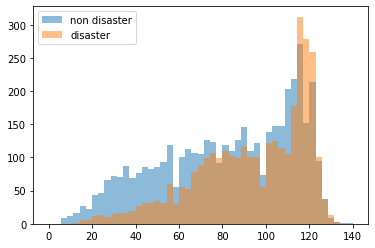

In [10]:
bins = np.linspace(0, 140, 50)
plt.hist(train[train['target'] == 0]['char_count'], alpha=0.5, bins=bins, label='non disaster')
plt.hist(train[train['target'] == 1]['char_count'], alpha=0.5, bins=bins, label='disaster')
plt.legend(loc='upper left')
plt.show()

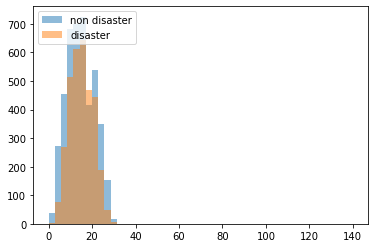

In [11]:
bins = np.linspace(0, 140, 50)
plt.hist(train[train['target'] == 0]['word_count'], alpha=0.5, bins=bins, label='non disaster')
plt.hist(train[train['target'] == 1]['word_count'], alpha=0.5, bins=bins, label='disaster')
plt.legend(loc='upper left')
plt.show()

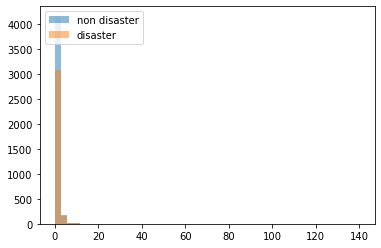

In [12]:
bins = np.linspace(0, 140, 50)
plt.hist(train[train['target'] == 0]['#_count'], alpha=0.5, bins=bins, label='non disaster')
plt.hist(train[train['target'] == 1]['#_count'], alpha=0.5, bins=bins, label='disaster')
plt.legend(loc='upper left')
plt.show()

In [13]:
train['city'] = np.nan
train['country'] = np.nan
train['location'] = train['location'].fillna('NaN')
for index, df in tqdm(train.iterrows()):
    text = df['location']
    ls = re.split('[,#]', text)
    train.loc[index, 'city'] = ls[0]
    if len(ls) > 1:
        train.loc[index, 'country'] = ls[1]
    else:
        train.loc[index, 'country'] = 'NaN'

7613it [00:04, 1656.91it/s]


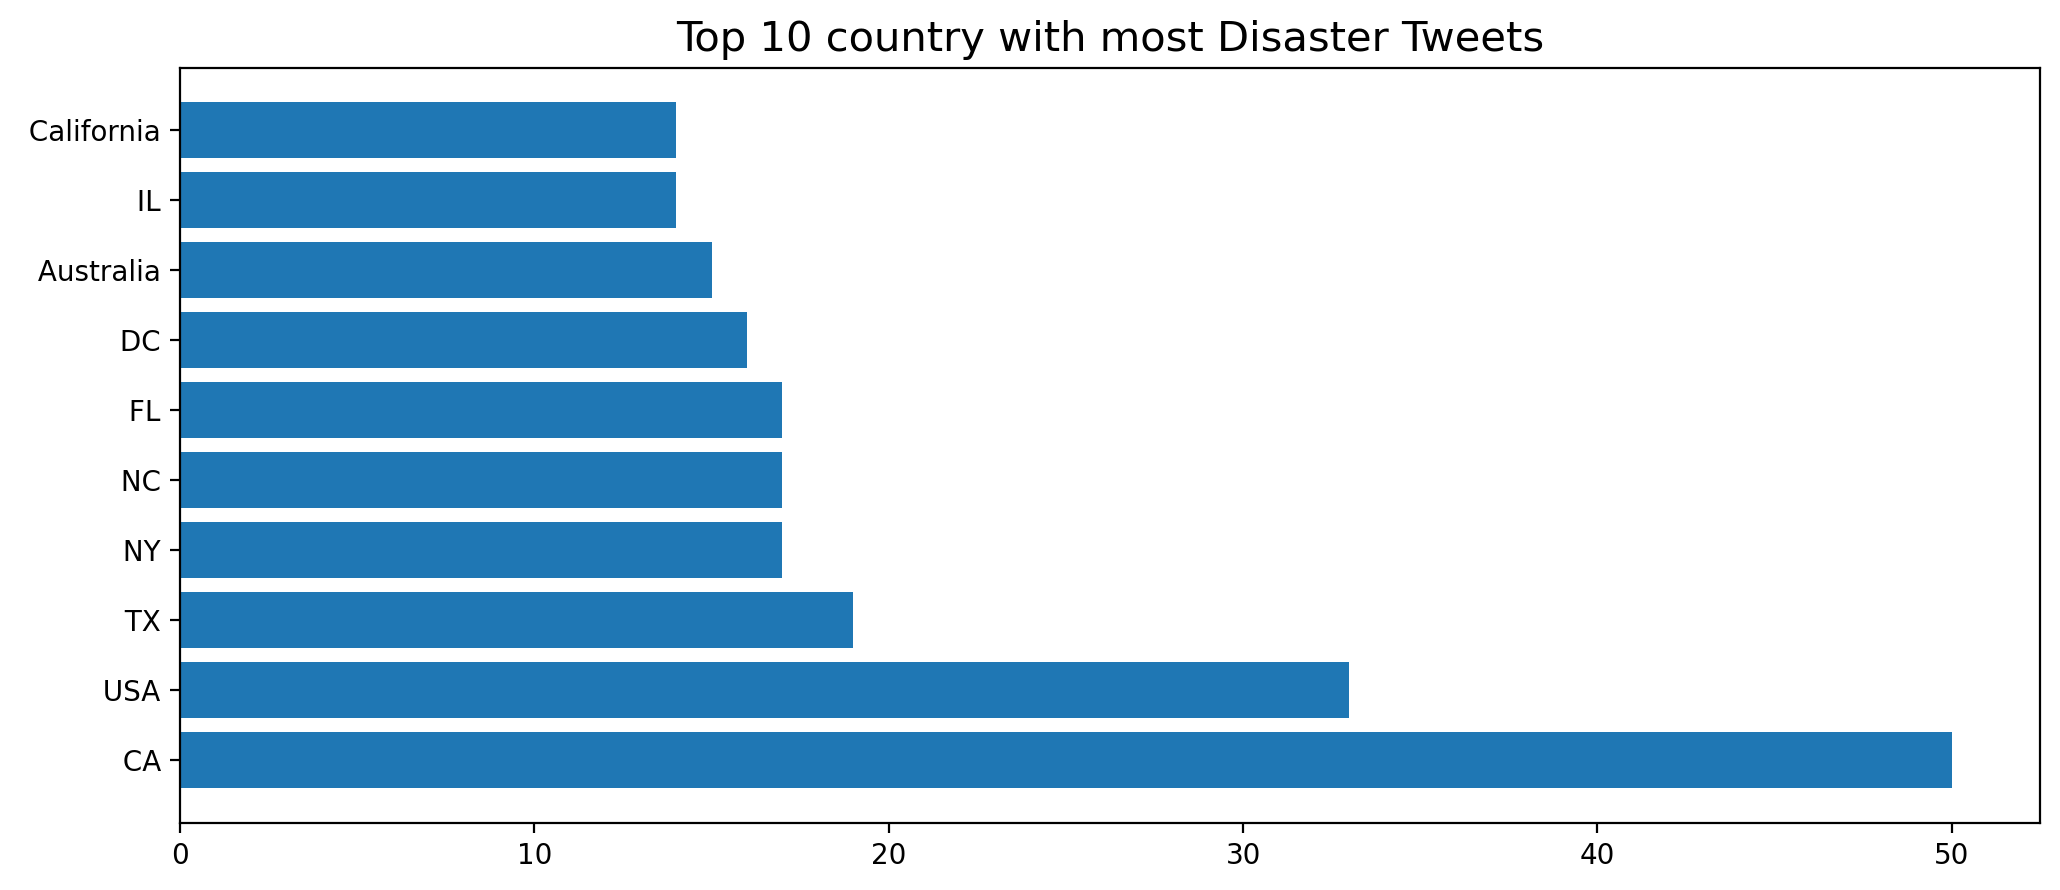

In [14]:
fig = plt.figure(figsize=(12, 5), dpi=200)
country_disaster = train[(train['target'] == 1) & (train['country'] != 'NaN')]['country'].value_counts()[:10]
plt.barh(country_disaster.index, country_disaster.values)
plt.title(f'Top 10 country with most Disaster Tweets', size=15)
plt.show()

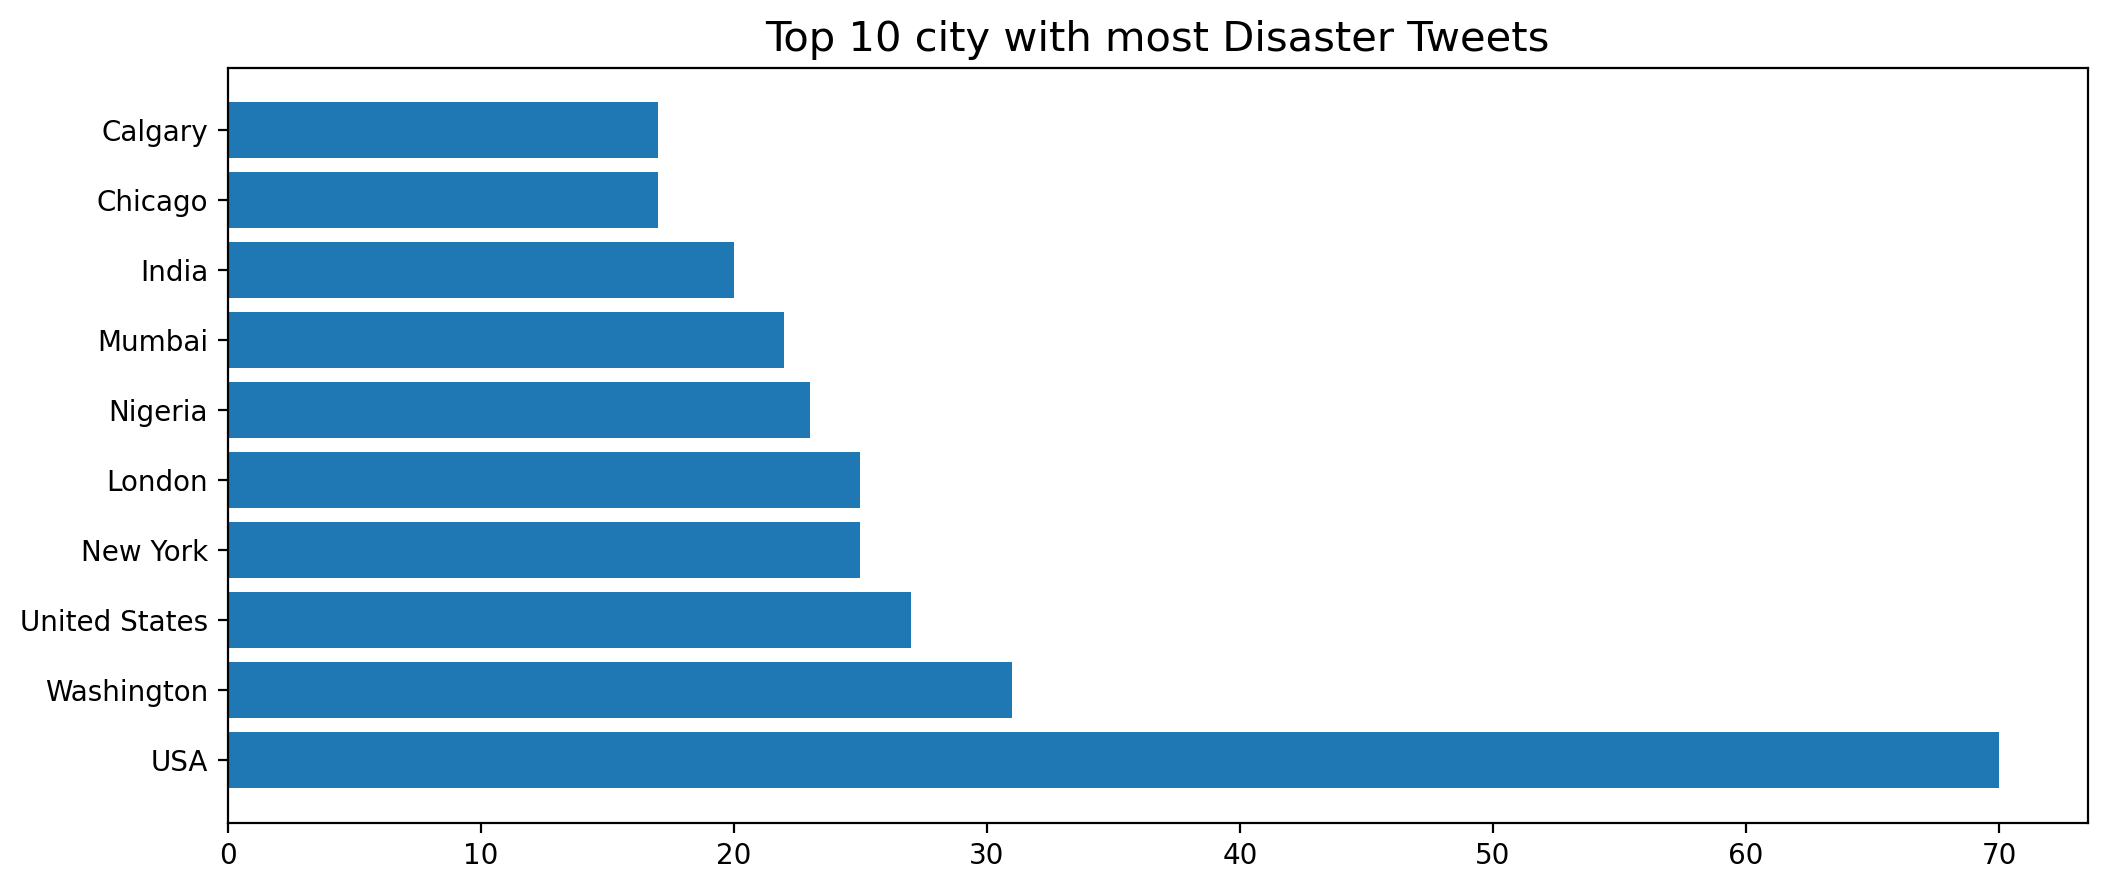

In [15]:
fig = plt.figure(figsize=(12, 5), dpi=200)
city_disaster = train[(train['target'] == 1) & (train['city'] != 'NaN')]['city'].value_counts()[:10]
plt.barh(city_disaster.index, city_disaster.values)
plt.title(f'Top 10 city with most Disaster Tweets', size=15)
plt.show()

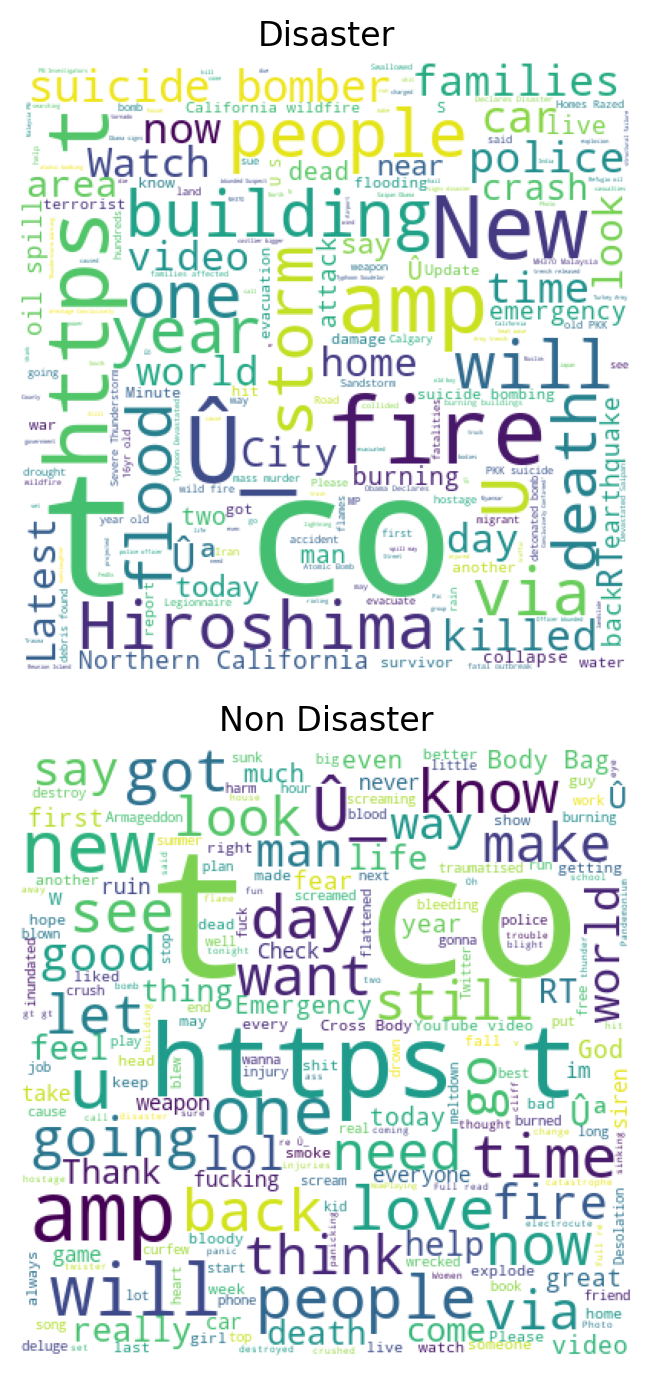

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(12, 7), dpi=200)
wc = WordCloud(width=400, height=400, background_color='white', stopwords=STOPWORDS)
disaster_text = ' '.join(train[train['target'] == 1]['text'].values.tolist())
word_disaster = wc.generate(disaster_text)
ax[0].imshow(word_disaster)
ax[0].set_title('Disaster', size=12)
ax[0].axis('off')

non_disaster_text = ' '.join(train[train['target'] == 0]['text'].values.tolist())
word_non_disaster = wc.generate(non_disaster_text)
ax[1].imshow(word_non_disaster)
ax[1].set_title('Non Disaster', size=12)
ax[1].axis('off')

plt.tight_layout()
plt.show()

# Tf-IDF 

In [69]:
stopwords = nltk.corpus.stopwords.words('english')
def clean_text(text):
    text = ''.join([w.lower() for w in text if w not in string.punctuation])
    tokens = re.split('\W+', text)
    cleaned = [w for w in tokens if w not in stopwords]
    return cleaned

In [76]:
x_train, x_valid, y_train, y_valid = train_test_split(train, train['target'], 
                                                      test_size=0.15, random_state=42)

In [86]:
tf_idf = TfidfVectorizer(encoding='unicode', min_df=2, analyzer=clean_text)
tf_idf.fit(x_train['text'])
x_train_vect = tf_idf.transform(x_train['text'])
x_valid_vect = tf_idf.transform(x_valid['text'])

In [93]:
rf = RandomForestClassifier()
rf_model = rf.fit(x_train_vect, y_train.values)

In [94]:
y_pred = rf_model.predict(x_valid_vect)

In [102]:
print(f'''Precision: {round(precision_score(y_valid, y_pred), 3)}
Recall: {round(recall_score(y_valid, y_pred), 3)}
Accuracy: {round((y_valid == y_pred).sum() / len(y_valid), 3)}''')

Precision: 0.757
Recall: 0.678
Accuracy: 0.768


# W2V pretrained

In [117]:
train['clean_text'] = train['text'].apply(lambda x: gensim.utils.simple_preprocess(x))

In [118]:
x_train, x_valid, y_train, y_valid = train_test_split(train['clean_text'], train['target'], 
                                                      test_size=0.15, random_state=42)

In [108]:
wiki_embeddings = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [171]:
w2v_pre_vect_train = np.array([np.array([wiki_embeddings[word] 
                                   for word in ls if word in wiki_embeddings.index_to_key]) 
                         for ls in x_train], dtype='object')

w2v_pre_vect_valid = np.array([np.array([wiki_embeddings[word] 
                                   for word in ls if word in wiki_embeddings.index_to_key]) 
                         for ls in x_valid], dtype='object')

In [172]:
w2v_pre_vect_mean_train = np.array([vec.mean(axis=0) if len(vec) != 0 else np.zeros(100) 
                              for vec in tqdm(w2v_pre_vect_train)])
w2v_pre_vect_mean_valid = np.array([vec.mean(axis=0) if len(vec) != 0 else np.zeros(100) 
                              for vec in tqdm(w2v_pre_vect_valid)])


100%|███████████████████████████████████████████████████████████████████████████| 6471/6471 [00:00<00:00, 59362.96it/s]

100%|███████████████████████████████████████████████████████████████████████████| 1142/1142 [00:00<00:00, 51908.35it/s]


In [174]:
rf = RandomForestClassifier()
rf_model = rf.fit(w2v_pre_vect_mean_train, y_train.values)

In [175]:
y_pred = rf_model.predict(w2v_pre_vect_mean_valid)

In [176]:
print(f'''Precision: {round(precision_score(y_valid, y_pred), 3)}
Recall: {round(recall_score(y_valid, y_pred), 3)}
Accuracy: {round((y_valid == y_pred).sum() / len(y_valid), 3)}''')

Precision: 0.822
Recall: 0.66
Accuracy: 0.792


# W2V model

In [178]:
w2v_model = gensim.models.Word2Vec(x_train, vector_size=100, window=5, min_count=2)

In [182]:
w2v_model_vect_train = np.array([np.array([w2v_model.wv[word] 
                                   for word in ls if word in w2v_model.wv.index_to_key]) 
                         for ls in x_train], dtype='object')

w2v_model_vect_valid = np.array([np.array([w2v_model.wv[word] 
                                   for word in ls if word in w2v_model.wv.index_to_key]) 
                         for ls in x_valid], dtype='object')

In [183]:
w2v_model_vect_mean_train = np.array([vec.mean(axis=0) if len(vec) != 0 else np.zeros(100) 
                                      for vec in tqdm(w2v_model_vect_train)])
w2v_model_vect_mean_valid = np.array([vec.mean(axis=0) if len(vec) != 0 else np.zeros(100) 
                                      for vec in tqdm(w2v_model_vect_valid)])


100%|███████████████████████████████████████████████████████████████████████████| 6471/6471 [00:00<00:00, 55303.47it/s]

100%|███████████████████████████████████████████████████████████████████████████| 1142/1142 [00:00<00:00, 54378.72it/s]


In [184]:
rf = RandomForestClassifier()
rf_model = rf.fit(w2v_model_vect_mean_train, y_train.values)

In [185]:
y_pred = rf_model.predict(w2v_model_vect_mean_valid)

In [186]:
print(f'''Precision: {round(precision_score(y_valid, y_pred), 3)}
Recall: {round(recall_score(y_valid, y_pred), 3)}
Accuracy: {round((y_valid == y_pred).sum() / len(y_valid), 3)}''')

Precision: 0.667
Recall: 0.56
Accuracy: 0.691


# D2V model

In [204]:
tagged_doc_train = [gensim.models.doc2vec.TaggedDocument(words, [index]) 
              for index, words in tqdm(enumerate(x_train))]

tagged_doc_valid = [gensim.models.doc2vec.TaggedDocument(words, [index]) 
              for index, words in tqdm(enumerate(x_valid))]


6471it [00:00, 462271.41it/s]

1142it [00:00, 380664.00it/s]


In [198]:
d2v_model = gensim.models.Doc2Vec(tagged_doc_train, vector_size=100, window=5, min_count=2)

In [212]:
d2v_vect_train = [d2v_model.infer_vector(v.words) for v in tagged_doc_train]
d2v_vect_valid = [d2v_model.infer_vector(v.words) for v in tagged_doc_valid]

In [213]:
rf = RandomForestClassifier()
rf_model = rf.fit(d2v_vect_train, y_train.values)
y_pred = rf_model.predict(d2v_vect_valid)
print(f'''Precision: {round(precision_score(y_valid, y_pred), 3)}
Recall: {round(recall_score(y_valid, y_pred), 3)}
Accuracy: {round((y_valid == y_pred).sum() / len(y_valid), 3)}''')

Precision: 0.733
Recall: 0.536
Accuracy: 0.716
